### Authors

* **Deepak Hazarika** 
* **Parinita Bora**
* **Gurudatta**

# Import Libraries

In [ ]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import logging
import sys
from datetime import datetime

now = datetime.now()

#sys.stdout = open('logfile' + str(now) + '.log','a')

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    filename='logfile.log',
                    filemode='a')

logging.info("Start " + str(now))
print("Start of logging V3 " + str(now))

Start of logging V3 2020-08-21 12:54:58.576144


## Params

* Batch_size
* learning rate

In [ ]:
BATCH_SIZE = 128
LR = 0.022
MODEL_VERSION = 2
modelinfo =  "Model version- " + str( MODEL_VERSION) + ", Bacth size- " + str(BATCH_SIZE) + ", Learning rate- " + str(LR) 

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       #transforms.RandomCrop(28 ),
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
modelinfo = modelinfo + " Random affine 10 and Random color jitter 0.1 + relu in conv6 + gap at end" 


In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=BATCH_SIZE)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        c_in = 1
        c_out = 9
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        c_in = 9
        c_out = 9
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 24
        
        c_in = 9
        c_out = 9
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 22

        # TRANSITION BLOCK 1

        c_in = 9
        c_out = 8
        
        self.convblock3a = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        
        c_in = 9
        c_out = 16
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 22

        # CONVOLUTION BLOCK 2
        c_in = 16
        c_out = 16
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 9
        c_in = 16
        c_out = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        ) # output_size = 7

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU()
        ) # output_size = 7

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=13, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(13),
            nn.ReLU()
        ) # output_size = 7


        c_in = 16
        c_out = 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, kernel_size=(1, 1), padding=0, bias=False),
            # nn.ReLU() NEVER!
        ) # output_size = 1

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        #x = self.convblock3a(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        #x = self.convblock8(x)
        
        x = self.convblock9(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 26, 26]              81
       BatchNorm2d-2            [-1, 9, 26, 26]              18
              ReLU-3            [-1, 9, 26, 26]               0
            Conv2d-4            [-1, 9, 24, 24]             729
       BatchNorm2d-5            [-1, 9, 24, 24]              18
              ReLU-6            [-1, 9, 24, 24]               0
            Conv2d-7            [-1, 9, 22, 22]             729
       BatchNorm2d-8            [-1, 9, 22, 22]              18
              ReLU-9            [-1, 9, 22, 22]               0
        MaxPool2d-10            [-1, 9, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,296
      BatchNorm2d-12             [-1, 16, 9, 9]              32
             ReLU-13             [-1, 16, 9, 9]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss.item(), correct, processed ,
        100. * correct / processed))
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

modelinfo = modelinfo + " call scheduler with step size " + str(6)

print(modelinfo)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

  0%|          | 0/469 [00:00<?, ?it/s]

Model version- 2, Bacth size- 128, Learning rate- 0.022 Random affine 10 and Random color jitter 0.1 + relu in conv6 + gap at end call scheduler with step size 6
EPOCH: 0


Loss=0.08577820658683777 Batch_id=468 Accuracy=87.64: 100%|██████████| 469/469 [00:48<00:00,  9.62it/s]


Train set: Average loss: 0.0858, Accuracy: 52583/60000 (87.64%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0793, Accuracy: 9760/10000 (97.60%)

EPOCH: 1


Loss=0.13078776001930237 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]


Train set: Average loss: 0.1308, Accuracy: 58288/60000 (97.15%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.16929204761981964 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:50<00:00,  9.37it/s]


Train set: Average loss: 0.1693, Accuracy: 58522/60000 (97.54%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


Loss=0.04165221378207207 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:50<00:00,  9.27it/s]


Train set: Average loss: 0.0417, Accuracy: 58678/60000 (97.80%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9891/10000 (98.91%)

EPOCH: 4


Loss=0.031107338145375252 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:50<00:00,  9.36it/s]


Train set: Average loss: 0.0311, Accuracy: 58874/60000 (98.12%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.019141534343361855 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:50<00:00,  9.37it/s]



Train set: Average loss: 0.0191, Accuracy: 58893/60000 (98.16%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.08008361607789993 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:49<00:00,  9.47it/s]


Train set: Average loss: 0.0801, Accuracy: 59144/60000 (98.57%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.08755797892808914 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:48<00:00,  9.62it/s]


Train set: Average loss: 0.0876, Accuracy: 59220/60000 (98.70%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9946/10000 (99.46%)

EPOCH: 8


Loss=0.06759312748908997 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


Train set: Average loss: 0.0676, Accuracy: 59241/60000 (98.73%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.007374849636107683 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:50<00:00,  9.37it/s]


Train set: Average loss: 0.0074, Accuracy: 59219/60000 (98.70%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 10


Loss=0.043790265917778015 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]


Train set: Average loss: 0.0438, Accuracy: 59231/60000 (98.72%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


Loss=0.06714247912168503 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]



Train set: Average loss: 0.0671, Accuracy: 59245/60000 (98.74%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

EPOCH: 12


Loss=0.06721147149801254 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:50<00:00,  9.35it/s]


Train set: Average loss: 0.0672, Accuracy: 59286/60000 (98.81%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9946/10000 (99.46%)

EPOCH: 13


Loss=0.08452523499727249 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:49<00:00,  9.45it/s]


Train set: Average loss: 0.0845, Accuracy: 59256/60000 (98.76%)




  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH: 14


Loss=0.008752868510782719 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:50<00:00,  9.34it/s]


Train set: Average loss: 0.0088, Accuracy: 59252/60000 (98.75%)




Test set: Average loss: 0.0175, Accuracy: 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

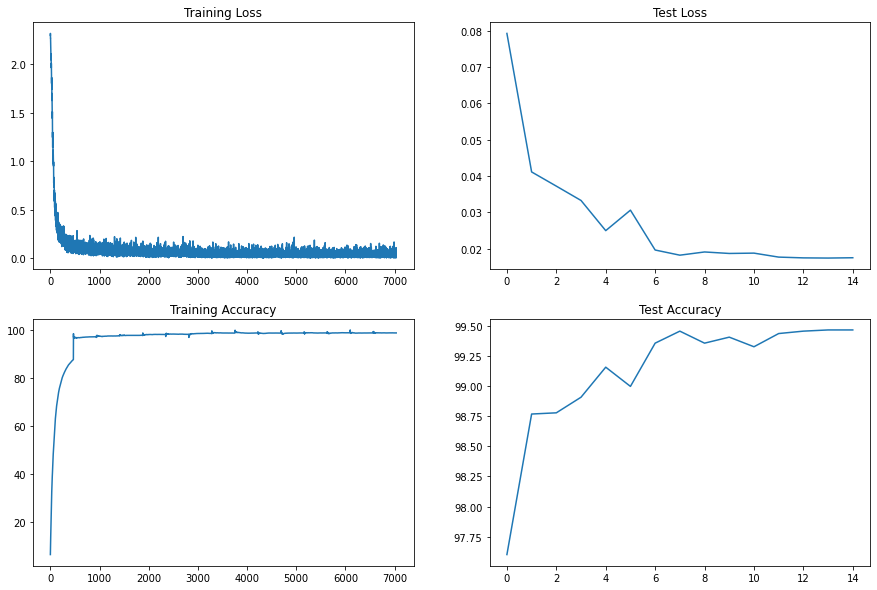

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
now = datetime.now()

print("End of logging V2" + str(now))

End of logging V22020-08-21 13:08:18.672740
